In [3]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
train_labels = pd.read_csv('Data/TrainLabels.csv')
submission = pd.read_csv('Data/SampleSubmission.csv')
true_labels = pd.read_csv('Data/true_labels.csv')

In [5]:
X_train = np.load('Data/X_train_final.npy')
X_test = np.load('Data/X_test_final.npy')

In [6]:
Y_train = train_labels.Prediction.values

In [7]:
train_labels

,IdFeedBack,Prediction
0,S02_Sess01_FB001,1
1,S02_Sess01_FB002,1
2,S02_Sess01_FB003,0
3,S02_Sess01_FB004,0
4,S02_Sess01_FB005,1
...,...,...
5435,S26_Sess05_FB096,1
5436,S26_Sess05_FB097,0
5437,S26_Sess05_FB098,0
5438,S26_Sess05_FB099,0


In [8]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ',  X_test.shape)

X_train shape:  (5440, 210)
X_test shape:  (3400, 210)


In [107]:
X_train = X_train.reshape((5440,20*20))
X_test = X_test.reshape((3400,20*20))

In [9]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=0.2)

## Random Forests

In [144]:
start = time.time()
clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=150, random_state=42)
clf.fit(x_train1, y_train1)

now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

Elapsed Time: 2 seconds


In [146]:
preds = clf.predict_proba(x_test1)[:,1]

In [147]:
def plot_roc(y, preds, model):
    fpr, tpr, thresholds = roc_curve(y, preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("max(tpr - fpr) w/ th = ", optimal_threshold)
    l1, = plt.plot([0, 1], [0, 1], '--')
    l2, = plt.plot(fpr, tpr, label = 'Random Forest')
    auc = roc_auc_score(y, preds)
    l = plt.legend([l2], [model+str(' AUC: %.2f' % auc)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

max(tpr - fpr) w/ th =  0.6933333333333334


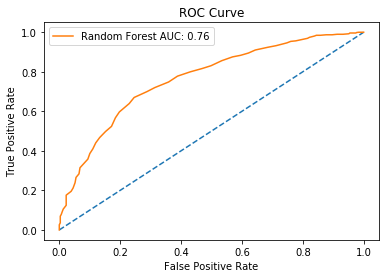

In [148]:
plot_roc(y_test1, preds, 'Random Forest')

In [9]:
params = {
    'n_estimators': [100,200,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,10,50,100]
}

In [10]:
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state=42)
cv = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1, verbose=5, refit='accuracy', cv=4)
cv.fit(X_train,Y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 18.7min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_

In [14]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score')['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.521680,0.365569,1.176135,0.227289,1,auto,100,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
1,2.741622,0.521117,0.675058,0.421479,1,auto,200,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
2,6.541156,0.585087,2.281829,0.771777,1,auto,500,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
3,14.225604,0.579375,1.220352,0.366931,1,auto,1000,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
4,5.372815,0.255646,1.080329,0.837969,1,sqrt,100,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
5,2.213030,0.299663,0.751772,0.193605,1,sqrt,200,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
6,5.768453,0.505435,1.282780,0.338463,1,sqrt,500,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
7,14.024614,1.085484,2.326262,0.962903,1,sqrt,1000,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
8,2.861468,1.238367,3.019022,0.874581,1,log2,100,"{'max_depth': 1, 'max_features': 'log2', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
9,4.580955,1.006996,1.012877,0.659329,1,log2,200,"{'max_depth': 1, 'max_features': 'log2', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1


In [276]:
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state=42, 
                                      max_depth = 1, max_features = 'auto', n_estimators = 100)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [279]:
probs = clf.predict_proba(X_test)[:,1]
probs

array([0.71356605, 0.71371877, 0.72758743, ..., 0.700673  , 0.71618348,
       0.71040439])

max(tpr - fpr) w/ th =  0.7072190880392419


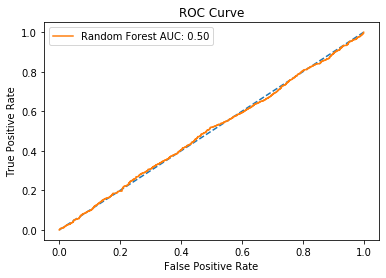

In [282]:
plot_roc(Y_test, probs[:-1], 'Random Forest')

In [152]:
true_labels = pd.read_csv('Data/true_labels.csv')
Y_test = true_labels['1'].values

In [153]:
def matrix_info(th, y, probs):
    preds = (probs >= th).astype(np.int)
    print('f1_score:')
    print(f1_score(y, preds))
    print('Confusion Matrix:')
    print(confusion_matrix(y,preds))
    print(classification_report(y,preds))

In [154]:
for i in np.arange(0.68,0.73,0.01):
    print(i)
    matrix_info(i, Y_train, probs)

0.68
f1_score:
0.8398450470392917
Confusion Matrix:
[[ 199 1391]
 [  56 3794]]
              precision    recall  f1-score   support

           0       0.78      0.13      0.22      1590
           1       0.73      0.99      0.84      3850

    accuracy                           0.73      5440
   macro avg       0.76      0.56      0.53      5440
weighted avg       0.75      0.73      0.66      5440

0.6900000000000001
f1_score:
0.8377735490009516
Confusion Matrix:
[[ 554 1036]
 [ 328 3522]]
              precision    recall  f1-score   support

           0       0.63      0.35      0.45      1590
           1       0.77      0.91      0.84      3850

    accuracy                           0.75      5440
   macro avg       0.70      0.63      0.64      5440
weighted avg       0.73      0.75      0.72      5440

0.7000000000000001
f1_score:
0.7824181843078187
Confusion Matrix:
[[ 994  596]
 [ 993 2857]]
              precision    recall  f1-score   support

           0       0.50   

In [158]:
matrix_info(0.68 ,Y_train, probs)

f1_score:
0.8398450470392917
Confusion Matrix:
[[ 199 1391]
 [  56 3794]]
              precision    recall  f1-score   support

           0       0.78      0.13      0.22      1590
           1       0.73      0.99      0.84      3850

    accuracy                           0.73      5440
   macro avg       0.76      0.56      0.53      5440
weighted avg       0.75      0.73      0.66      5440



In [159]:
submission.Predicition = preds

C:\Users\taq19\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [154]:
submission.to_csv('submission.csv', index=None)

## Logistic Regression

In [120]:
from sklearn.linear_model import LogisticRegression

In [142]:
clf = LogisticRegression(random_state=0, max_iter=1000, C = 0.1, penalty = 'l1').fit(x_train1, y_train1)
probs = clf.predict_proba(x_test1)[:,1]

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [122]:
probs

array([0.93160791, 0.91035478, 0.31679332, ..., 0.8560108 , 0.81947571,
       0.96769439])

max(tpr - fpr) w/ th =  0.7063613939602489


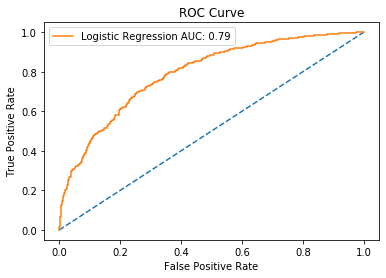

In [143]:
plot_roc(y_test1, probs, 'Logistic Regression')

In [124]:
for i in np.arange(0.5,0.7,0.05):
    print(i)
    matrix_info(i, y_test1, probs)

0.5


NameError: name 'matrix_info' is not defined

In [282]:
matrix_info(0.55, y_test1, probs)

f1_score:
0.8162746344564528
Confusion Matrix:
[[157 176]
 [113 642]]
              precision    recall  f1-score   support

           0       0.58      0.47      0.52       333
           1       0.78      0.85      0.82       755

    accuracy                           0.73      1088
   macro avg       0.68      0.66      0.67      1088
weighted avg       0.72      0.73      0.73      1088



In [129]:
params = {
    "C" : np.logspace(-3,3,7), 
    "penalty" : ["l1","l2"]
}

In [130]:
clf = LogisticRegression(random_state=42, max_iter=1000)
cv = GridSearchCV(clf, param_grid=params, n_jobs=-1, verbose=10, cv=4)

In [131]:
cv.fit(X_train, Y_train)

Fitting 4 folds for each of 14 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  47 out of  56 | elapsed:    5.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  53 out of  56 | elapsed:    6.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    6.4s finished
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [133]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'C': 0.1, 'penalty': 'l1'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
4,0.426116,0.035696,0.007226,7.343693e-03,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",0.737693,0.732550,0.746137,0.731420,0.736949,0.005806,1
3,0.637098,0.055697,0.002743,4.321556e-04,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.734754,0.718589,0.740250,0.728477,0.730515,0.008049,2
2,0.289321,0.019645,0.002742,4.311920e-04,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",0.724467,0.731080,0.724062,0.735835,0.728860,0.004896,3
5,1.086861,0.072127,0.002241,4.339272e-04,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.736958,0.715650,0.729213,0.725533,0.726838,0.007666,4
6,0.769711,0.045774,0.002739,4.299744e-04,1,l1,"{'C': 1.0, 'penalty': 'l1'}",0.735489,0.713446,0.731420,0.722590,0.725735,0.008493,5
7,1.292467,0.197123,0.003740,1.474329e-03,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.731815,0.708303,0.727741,0.727005,0.723713,0.009088,6
10,0.979130,0.057120,0.002993,7.633119e-07,100,l1,"{'C': 100.0, 'penalty': 'l1'}",0.731080,0.709037,0.726269,0.725533,0.722978,0.008330,7
8,0.988899,0.074675,0.002742,4.317779e-04,10,l1,"{'C': 10.0, 'penalty': 'l1'}",0.731080,0.709037,0.726269,0.724798,0.722794,0.008279,8
11,1.228465,0.102194,0.003741,1.295847e-03,100,l2,"{'C': 100.0, 'penalty': 'l2'}",0.731080,0.709037,0.725533,0.725533,0.722794,0.008263,8
12,0.861445,0.115810,0.002743,4.320188e-04,1000,l1,"{'C': 1000.0, 'penalty': 'l1'}",0.731080,0.709037,0.725533,0.725533,0.722794,0.008263,8


In [166]:
clf = LogisticRegression(C = 0.1, penalty = 'l1').fit(X_train, Y_train)
probs = clf.predict_proba(X_test)[:,1]

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [167]:
Y_test = true_labels['1'].values

max(tpr - fpr) w/ th =  0.44056774936596205


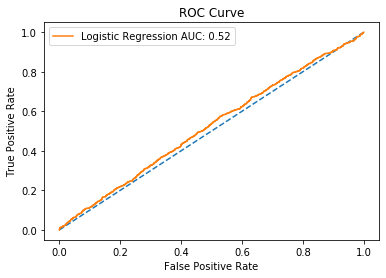

In [168]:
plot_roc(Y_test, probs[:-1], 'Logistic Regression')

In [234]:
for i in np.arange(0.5,0.7,0.05):
    print(i)
    matrix_info(i, Y_test,probs[:-1])

0.5
Accuracy:
0.6799058546631362
Confusion Matrix:
[[  68  921]
 [ 167 2243]]
              precision    recall  f1-score   support

           0       0.29      0.07      0.11       989
           1       0.71      0.93      0.80      2410

    accuracy                           0.68      3399
   macro avg       0.50      0.50      0.46      3399
weighted avg       0.59      0.68      0.60      3399

0.55
Accuracy:
0.6578405413356869
Confusion Matrix:
[[ 111  878]
 [ 285 2125]]
              precision    recall  f1-score   support

           0       0.28      0.11      0.16       989
           1       0.71      0.88      0.79      2410

    accuracy                           0.66      3399
   macro avg       0.49      0.50      0.47      3399
weighted avg       0.58      0.66      0.60      3399

0.6000000000000001
Accuracy:
0.6363636363636364
Confusion Matrix:
[[ 180  809]
 [ 427 1983]]
              precision    recall  f1-score   support

           0       0.30      0.18      0.

## Support Vector Machines

took 25+ minutes to run so I stopped it

In [21]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=0.2)
scaler = StandardScaler()

In [27]:
start = time.time()

svclassifier = SVC(kernel='linear')
svclassifier.fit(scaler.fit_transform(x_train1), y_train1)
now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

Elapsed Time: 30 seconds


In [269]:
svm_preds = svclassifier.predict(scaler.transform(x_test1))
svm_preds

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

max(tpr - fpr) w/ th =  0.6933333333333334


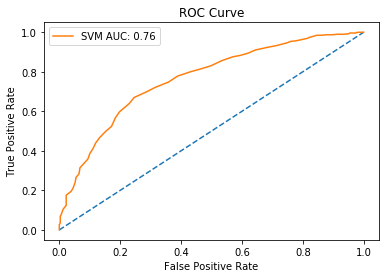

In [270]:
plot_roc(y_test1, preds, 'SVM')

In [271]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(scaler.fit_transform(X_train), Y_train)
now = time.time()

In [273]:
svm_preds = svclassifier.predict(scaler.transform(X_test))

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [20]:
params = {
    'C': [0.1, 0.5, 1, 5], 
    'kernel': ['rbf'], 
    'degree': [2, 3, 7, 10],
    'gamma': np.power(5, np.linspace(-2,5, 10)),
    'max_iter': [100000]
}

In [24]:
svc = SVC()
cv = GridSearchCV(svc, param_grid=params, scoring='accuracy', n_jobs=-1, verbose=20, refit='accuracy', cv=4)

In [ ]:
cv.fit(scaler.fit_transform(X_train), Y_train)

Fitting 4 folds for each of 160 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 10.3min
[Paralle

## ElasticNet

In [30]:
from sklearn.linear_model import ElasticNet

In [233]:
en = ElasticNet(random_state = 42, normalize='True', alpha = 0.0001, l1_ratio = 0.4)
en.fit(x_train1,y_train1)
probs = en.predict(x_test1)

max(tpr - fpr) w/ th =  0.6365293399652618


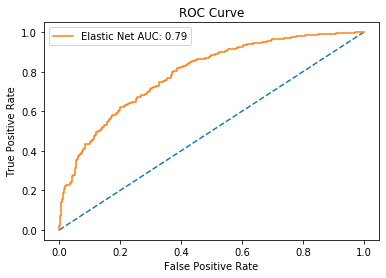

In [234]:
plot_roc(y_test1, probs, 'Elastic Net')

In [236]:
probs

array([0.83627109, 0.83957945, 0.50115662, ..., 0.79859038, 0.74949419,
       0.88814628])

In [48]:
en = ElasticNet()
cv = GridSearchCV(en, param_grid=params, n_jobs=-1, verbose=10, cv=4)
cv.fit(X_train, Y_train)

Fitting 4 folds for each of 140 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [50]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'alpha': 0.0001, 'l1_ratio': 0.4, 'normalize': 'True'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
8,0.214476,0.019911,0.003989,0.001727,0.0001,0.4,True,"{'alpha': 0.0001, 'l1_ratio': 0.4, 'normalize'...",0.103133,0.019431,0.159999,0.138800,0.105341,0.053602,1
9,0.218162,0.021583,0.003495,0.000495,0.0001,0.4,False,"{'alpha': 0.0001, 'l1_ratio': 0.4, 'normalize'...",0.103133,0.019431,0.159999,0.138800,0.105341,0.053602,1
18,0.204204,0.010179,0.003490,0.000499,0.0001,0.9,True,"{'alpha': 0.0001, 'l1_ratio': 0.9, 'normalize'...",0.101939,0.020604,0.160813,0.137970,0.105332,0.053230,3
19,0.216671,0.018421,0.006237,0.002849,0.0001,0.9,False,"{'alpha': 0.0001, 'l1_ratio': 0.9, 'normalize'...",0.101939,0.020604,0.160813,0.137970,0.105332,0.053230,3
6,0.215934,0.026701,0.004237,0.001086,0.0001,0.3,True,"{'alpha': 0.0001, 'l1_ratio': 0.30000000000000...",0.102905,0.019621,0.160101,0.138683,0.105327,0.053536,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.164894,0.009351,0.005404,0.001583,0.1,0.5,False,"{'alpha': 0.1, 'l1_ratio': 0.5, 'normalize': '...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,53
70,0.168300,0.011070,0.004239,0.001635,0.1,0.5,True,"{'alpha': 0.1, 'l1_ratio': 0.5, 'normalize': '...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,53
138,0.166553,0.023508,0.004736,0.001295,100,0.9,True,"{'alpha': 100, 'l1_ratio': 0.9, 'normalize': '...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,53
78,0.168551,0.016400,0.004735,0.001475,0.1,0.9,True,"{'alpha': 0.1, 'l1_ratio': 0.9, 'normalize': '...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,53


In [263]:
en = ElasticNet()
en.fit(X_train, Y_train)
probs = en.predict(X_test)

In [264]:
probs

array([0.70772059, 0.70772059, 0.70772059, ..., 0.70772059, 0.70772059,
       0.70772059])

In [254]:
probs

array([0.70772059, 0.70772059, 0.70772059, ..., 0.70772059, 0.70772059,
       0.70772059])

max(tpr - fpr) w/ th =  1.7077205882352942


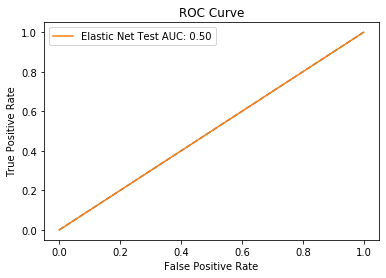

In [240]:
plot_roc(Y_test, probs[:-1], 'Elastic Net Test')

## LDA

In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [213]:
lda = LDA(solver = 'svd', n_components=None)
lda.fit(x_train1, y_train1)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [216]:
probs = lda.predict_proba(x_test1)[:,1]

max(tpr - fpr) w/ th =  0.7133437545697843


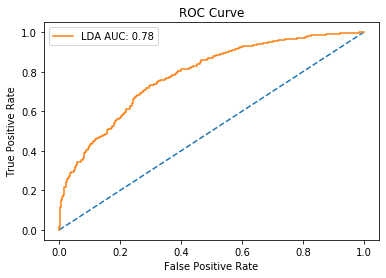

In [215]:
plot_roc(y_test1, probs, 'LDA')

In [115]:
params = {
    'solver': ['svd','lsqr','eigen'],
    'n_components' : [5,10,15,20,25,30,35,None]
}

In [117]:
params = {
    'solver': ['lsqr','eigen'],
    'shrinkage' : [None, 'auto'],
    'n_components' : [5,10,15,20,25,30,35,None]
}

In [118]:
lda = LDA()
cv = GridSearchCV(lda, param_grid=params, n_jobs=-1, verbose=10, cv=5)
cv.fit(X_train, Y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   17.2s finished
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_co

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='warn', n_jobs=-1,
             param_grid={'n_components': [5, 10, 15, 20, 25, 30, 35, None],
                         'shrinkage': [None, 'auto'],
                         'solver': ['lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [119]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][1])
cv_results.sort_values('rank_test_score')

best params:  {'n_components': 35, 'shrinkage': 'auto', 'solver': 'eigen'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,param_shrinkage,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.896636,0.069930,0.001994,6.296960e-04,20,auto,eigen,"{'n_components': 20, 'shrinkage': 'auto', 'sol...",0.722426,0.700368,0.718750,0.731618,0.699449,0.714522,0.012650,1
27,0.828212,0.098574,0.002594,7.977606e-04,35,auto,eigen,"{'n_components': 35, 'shrinkage': 'auto', 'sol...",0.722426,0.700368,0.718750,0.731618,0.699449,0.714522,0.012650,1
26,0.578677,0.088799,0.001995,4.909339e-07,35,auto,lsqr,"{'n_components': 35, 'shrinkage': 'auto', 'sol...",0.722426,0.700368,0.718750,0.731618,0.699449,0.714522,0.012650,1
23,0.826513,0.103520,0.001595,4.877447e-04,30,auto,eigen,"{'n_components': 30, 'shrinkage': 'auto', 'sol...",0.722426,0.700368,0.718750,0.731618,0.699449,0.714522,0.012650,1
22,0.561513,0.058548,0.002194,3.989942e-04,30,auto,lsqr,"{'n_components': 30, 'shrinkage': 'auto', 'sol...",0.722426,0.700368,0.718750,0.731618,0.699449,0.714522,0.012650,1
19,0.825393,0.042306,0.002196,4.013316e-04,25,auto,eigen,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.722426,0.700368,0.718750,0.731618,0.699449,0.714522,0.012650,1
18,0.654956,0.067206,0.002593,4.888705e-04,25,auto,lsqr,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.722426,0.700368,0.718750,0.731618,0.699449,0.714522,0.012650,1
30,0.672715,0.109423,0.003790,1.933089e-03,None,auto,lsqr,"{'n_components': None, 'shrinkage': 'auto', 's...",0.722426,0.700368,0.718750,0.731618,0.699449,0.714522,0.012650,1
14,0.619744,0.102165,0.002595,4.895513e-04,20,auto,lsqr,"{'n_components': 20, 'shrinkage': 'auto', 'sol...",0.722426,0.700368,0.718750,0.731618,0.699449,0.714522,0.012650,1
11,0.856335,0.069692,0.002389,4.928503e-04,15,auto,eigen,"{'n_components': 15, 'shrinkage': 'auto', 'sol...",0.722426,0.700368,0.718750,0.731618,0.699449,0.714522,0.012650,1


In [265]:
lda = LDA(solver = 'svd', n_components=None)
lda.fit(X_train, Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [266]:
probs = lda.predict_proba(X_test)[:,1]

In [268]:
probs

array([0.0004257 , 0.00132605, 0.00189334, ..., 0.00014405, 0.0010585 ,
       0.00124913])

max(tpr - fpr) w/ th =  0.0004976943651162147


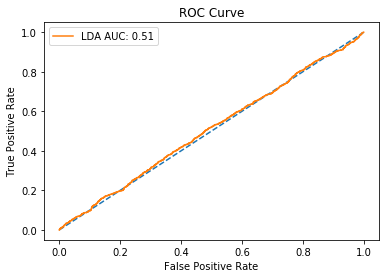

In [267]:
plot_roc(Y_test, probs[:-1], 'LDA')

In [229]:
probs

array([0.0004257 , 0.00132605, 0.00189334, ..., 0.00014405, 0.0010585 ,
       0.00124913])